# Chapter 9

## Section 9.1: Bayesian Networks

In [4]:
import pandas as pd
train = pd.read_csv('./data/train.csv')

In [3]:
# Listing 9.1: The chances of survival
def chance_to_survive(age):
    pop = train[train.Age.eq(age)]
    surv = pop[pop.Survived.eq(1)]
    prob = len(surv)/(len(pop)+1)
    return "A {}-year old passenger had a chance to survive of {}".format(age, prob)

print(chance_to_survive(47))
print(chance_to_survive(48))

A 47-year old passenger had a chance to survive of 0.1
A 48-year old passenger had a chance to survive of 0.6


In [5]:
# Listing 9.2: Survival of children
# max age of a child
max_child_age = 8

# probability to survive of children
pop_child = train[train.Age.le(max_child_age)]
surv_child = pop_child[pop_child.Survived.eq(1)]
p_child = len(surv_child)/len(pop_child)

# probability to survive of adults
pop_adult = train[train.Age.gt(max_child_age)]
surv_adult = pop_adult[pop_adult.Survived.eq(1)]
p_adult = len(surv_adult)/len(pop_adult)

print("{} children had a chance to survive of {}".format(len(pop_child), round(p_child, 2)))
print("{} adults had a chance to survive of {}".format(len(pop_adult), round(p_adult, 2)))

54 children had a chance to survive of 0.67
660 adults had a chance to survive of 0.38


## Section 9.2: Composing Quantum ComputingControls

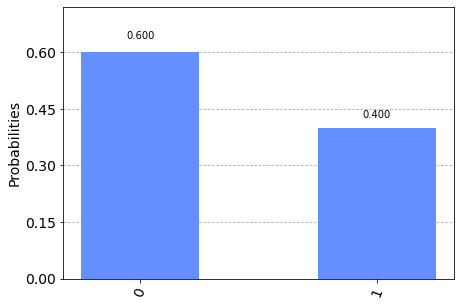

In [7]:
# Listing 9.3: Specify the marginal probability
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import asin, sqrt

def prob_to_angle(prob):
    """
    Converts a given P(psi) value into an equivalent theta value.
    """
    return 2*asin(sqrt(prob))
    
qc = QuantumCircuit(1)

# Set qubit to prior
qc.ry(prob_to_angle(0.4), 0)

# execute the qc
results = execute(qc,Aer.get_backend('statevector_simulator')).result().get_counts()
plot_histogram(results)

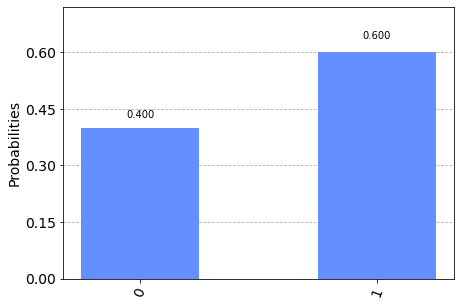

In [8]:
# Listing 9.4: Use the X‐gate to work with the remainder
qc = QuantumCircuit(1)

# Set qubit to prior
qc.ry(prob_to_angle(0.4), 0)

# Switch the qubit's value
qc.x(0)

# execute the qc
results = execute(qc,Aer.get_backend('statevector_simulator')).result().get_counts()
plot_histogram(results)

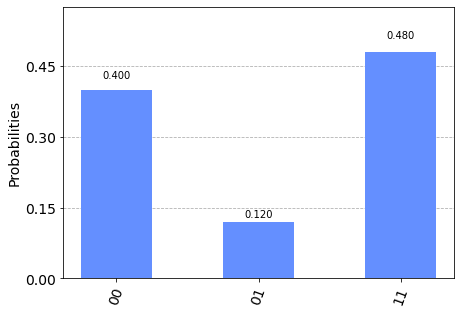

In [9]:
# Listing 9.5: Calculate the joint probability
qc = QuantumCircuit(2)

# Set qubit to prior
qc.ry(prob_to_angle(0.4), 0)

# Switch the qubit's value
qc.x(0)

# Calculate the joint probability of NOT-prior and an event
qc.cry(prob_to_angle(0.8), 0,1)

# execute the qc
results = execute(qc,Aer.get_backend('statevector_simulator')).result().get_counts()
plot_histogram(results)

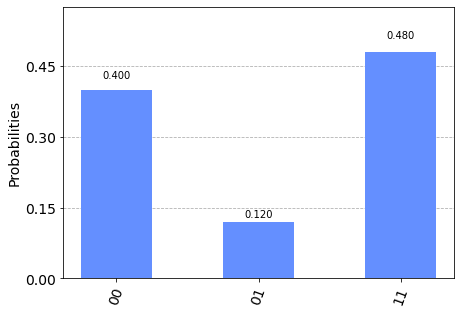

In [10]:
# Listing 9.6: Decomposition of the CRY‐gate
qc = QuantumCircuit(2)

# Set qubit to prior
qc.ry(prob_to_angle(0.4), 0)

# Switch the qubit's value
qc.x(0)

# Apply half of the event's probability
qc.ry(prob_to_angle(0.8)/2, 1)

# entangle qubits 0 and 1
qc.cx(0,1)

# Apply the other half of ev_b
qc.ry(-prob_to_angle(0.8)/2, 1)

# unentganle qubits 0 and 1
qc.cx(0,1)

# execute the qc
results = execute(qc,Aer.get_backend('statevector_simulator')).result().get_counts()
plot_histogram(results)

In [11]:
# Listing 9.7: The CCNOT‐function
from math import pi
theta = pi/2

def ccnot(qc):
    # Apply the first half of the rotatione
    qc.cry(theta, 1,2)

    # This sequence has no effect if both control qubits
    # are in state |1>
    qc.cx(0,1)
    qc.cry(-theta,1,2)
    qc.cx(0,1)

    # Apply the second half of the rotation
    qc.cry(theta, 0,2)

    # execute the qc
    return execute(qc,Aer.get_backend('statevector_simulator')).result().get_counts()

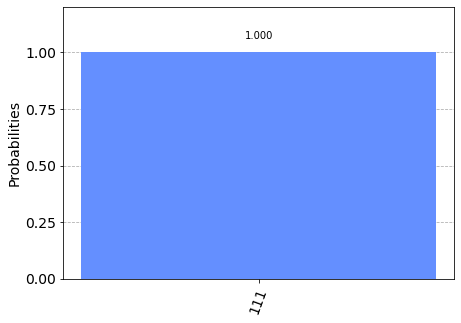

In [12]:
# Listing 9.8: The CCNOT‐gate with both control qubits in state |1>
qc = QuantumCircuit(3)

# set both qubits to |1>
qc.x(0)
qc.x(1)

# apply the ccnot-gate and execute the qc
results = ccnot(qc)
plot_histogram(results)

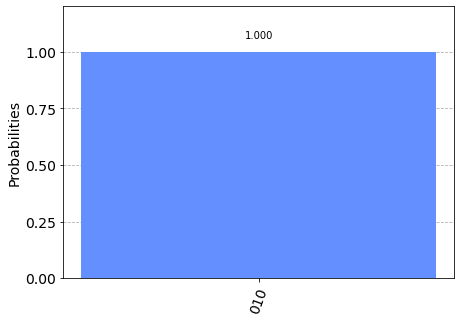

In [13]:
# Listing 9.9: The CCNOT‐gate with only control qubit q1 in state |1>
qc = QuantumCircuit(3)

# set only qubit q_1 to |1>
qc.x(1)

# apply the ccnot-gate and execute the qc
results = ccnot(qc)
plot_histogram(results)

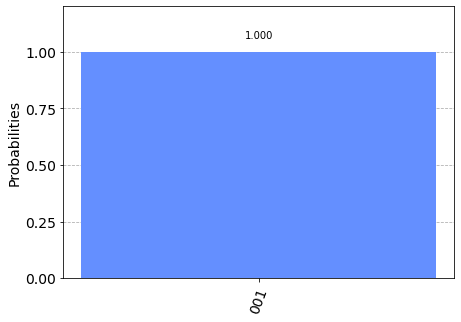

In [14]:
# Listing 9.10: The CCNOT‐gate with only control qubit q0 in state |1>
qc = QuantumCircuit(3)

# set only qubit q_0 to |1>
qc.x(0)

# apply the ccnot-gate and execute the qc
results = ccnot(qc)
plot_histogram(results)

## Section 9.3: Circuit implementation

In [15]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit import ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import asin, sqrt

import pandas as pd
train = pd.read_csv('./data/train.csv')

def prob_to_angle(prob):
    """
    Converts a given P(psi) value into an equivalent theta value.
    """
    return 2*asin(sqrt(prob))

In [16]:
# Listing 9.11: Initialize the parent nodes
# the maximum age of a passenger we consider as a child
max_child_age = 8

# probability of being a child
population_child = train[train.Age.le(max_child_age)]
p_child = len(population_child)/len(train)

# probability of being female
population_female = train[train.Sex.eq("female")]
p_female = len(population_female)/len(train)

# Initialize the quantum circuit
qc = QuantumCircuit(3)

# Set qubit0 to p_child
qc.ry(prob_to_angle(p_child), 0)

# Set qubit1 to p_female
qc.ry(prob_to_angle(p_female), 1)

In [18]:
# Listing 9.12: Definition of the CCRY‐gate
def ccry(qc, theta, control1, control2, controlled):
    qc.cry(theta/2, control2, controlled)
    qc.cx(control1, control2)
    qc.cry(-theta/2, control2, controlled)
    qc.cx(control1, control2)
    qc.cry(theta/2, control1, controlled)

In [19]:
# Listing 9.13: Calculate the conditional probabilities
# female children
population_female=train[train.Sex.eq("female")]
population_f_c=population_female[population_female.Age.le(max_child_age)]
surv_f_c=population_f_c[population_f_c.Survived.eq(1)]
p_surv_f_c=len(surv_f_c)/len(population_f_c)

# female adults
population_f_a=population_female[population_female.Age.gt(max_child_age)]
surv_f_a=population_f_a[population_f_a.Survived.eq(1)]
p_surv_f_a=len(surv_f_a)/len(population_f_a)

# male children
population_male=train[train.Sex.eq("male")]
population_m_c=population_male[population_male.Age.le(max_child_age)]
surv_m_c=population_m_c[population_m_c.Survived.eq(1)]
p_surv_m_c=len(surv_m_c)/len(population_m_c)

# male adults
population_m_a=population_male[population_male.Age.gt(max_child_age)]
surv_m_a=population_m_a[population_m_a.Survived.eq(1)]
p_surv_m_a=len(surv_m_a)/len(population_m_a)

In [20]:
# Listing 9.14: Initialize the child node
# set state |00> to conditional probability of male adults
qc.x(0)
qc.x(1)
ccry(qc,prob_to_angle(p_surv_m_a),0,1,2)
qc.x(0)
qc.x(1)

# set state |01> to conditional probability of male children
qc.x(0)
ccry(qc,prob_to_angle(p_surv_m_c),0,1,2)
qc.x(0)

# set state |10> to conditional probability of female adults
qc.x(1)
ccry(qc,prob_to_angle(p_surv_f_a),0,1,2)
qc.x(1)

# set state |11> to conditional probability of female children
ccry(qc,prob_to_angle(p_surv_f_c),0,1,2)

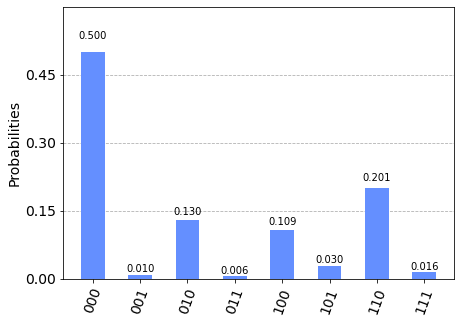

In [21]:
# Listing 9.15: Execute the circuit
# execute the qc
results = execute(qc,Aer.get_backend('statevector_simulator')).result().get_counts()
plot_histogram(results)

In [22]:
# Listing 9.16: A quantum circuit with classical register
qr = QuantumRegister(3)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr, cr)

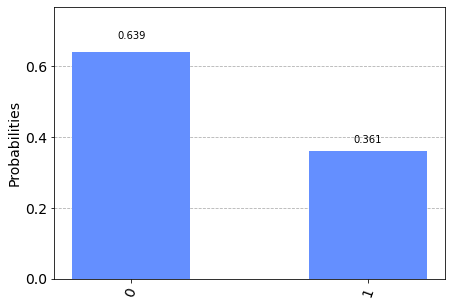

In [23]:
# Listing 9.17: Run the circuit including a measurement

# -- INCLUDE ALL GATES HERE --
# Set qubit0 to p_child
qc.ry(prob_to_angle(p_child), 0)

# Set qubit1 to p_female
qc.ry(prob_to_angle(p_female), 1)

# set state |00> to conditional probability of male adults
qc.x(0)
qc.x(1)
ccry(qc,prob_to_angle(p_surv_m_a),0,1,2)
qc.x(0)
qc.x(1)

# set state |01> to conditional probability of male children
qc.x(0)
ccry(qc,prob_to_angle(p_surv_m_c),0,1,2)
qc.x(0)

# set state |10> to conditional probability of female adults
qc.x(1)
ccry(qc,prob_to_angle(p_surv_f_a),0,1,2)
qc.x(1)

# set state |11> to conditional probability of female children
ccry(qc,prob_to_angle(p_surv_f_c),0,1,2)

qc.measure(qr[2], cr[0])
results = execute(qc,Aer.get_backend('qasm_simulator'), shots=1000).result().get_counts()
plot_histogram(results)